In [1]:
import os
import sys
import random

#TODO Make universal imports for all py files?

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
sys.modules['keras'] = keras

import numpy as np

from dice import dice_coef, dice_loss
from generator import DataGen
from visualize import display_slice_from_batch

seed = 2019
random.seed = seed
#TODO make config[seed] and fix below
#np.random.seed = seed
tf.seed = seed

c:\users\gauth\appdata\local\continuum\anaconda3\envs\pylattice_3d_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\gauth\appdata\local\continuum\anaconda3\envs\pylattice_3d_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\gauth\appdata\local\continuum\anaconda3\envs\pylattice_3d_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.d

In [2]:
patch_size = 32 # The size of the cube volumes in quickstart-gendata. You specified this in the previous notebook.
percent_covered = 1e-10
train_path = "quickstart-gendata/train"
model_path = "jan30_largeframe_32_nonzero_standardized_local.h5" # Name your model
epochs = 70
patience = 4
batch_size = 2

train_ids = next(os.walk(train_path))[1] # Returns all directories under train_path

val_data_size = 8 # Needs to be greater than batch_size

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=patch_size, patch_size=patch_size,
              percent_covered = percent_covered)
x, y = gen.__getitem__(0)
#0 - 37
print(x.shape, y.shape)

(2, 32, 32, 32, 1) (2, 32, 32, 32, 1)


(32, 32, 1)
2.7157068998056655
1.0


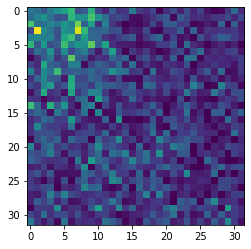

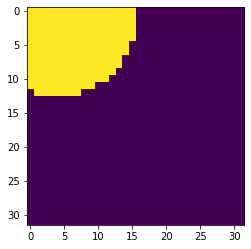

In [7]:
# View patches from the batch generated above.
# Change z to look at different slices.

n=0
z=23

display_slice_from_batch(x, n, z)
print(x[n, :, :, z].shape)
print(np.amax(x[n, :, :, z]))


display_slice_from_batch(y, n, z)
print(np.amax(y[n, :, :, :]))


In [8]:
# Neural network blocks
def down_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool3D((2, 2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    us = keras.layers.Conv3DTranspose(filters*4, (2, 2, 2), (2, 2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [9]:
# Model Architecture
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [32, 64, 128, 256]
    inputs = keras.layers.Input((patch_size, patch_size, patch_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #32 -> 16
    c2, p2 = down_block(p1, f[1]) #16 -> 8
    c3, p3 = down_block(p2, f[2]) #8 -> 4
    #c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p3, f[3])
    
    u1 = up_block(bn, c3, f[2]) #4 -> 8
    u2 = up_block(u1, c2, f[1]) #8 -> 16
    u3 = up_block(u2, c1, f[0]) #16 -> 32
    #u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")(u3)
    model = keras.models.Model(inputs, outputs)
    return model

In [11]:
# Create model
model = UNet()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss=dice_loss(smooth=1.), metrics=[dice_coef, 'accuracy'])#, sample_weight_mode="temporal")
model.summary()

#TODO Does valid_gen use percent_covered = 0 or nonzero?
train_gen = DataGen(train_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)
valid_gen = DataGen(valid_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
conv3d_15 (Conv3D)              (None, 32, 32, 32, 3 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_16 (Conv3D)              (None, 32, 32, 32, 6 55360       conv3d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_3 (MaxPooling3D)  (None, 16, 16, 16, 6 0           conv3d_16[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Train the model
train_steps = len(train_ids)*8//batch_size
valid_steps = len(valid_ids)*8//batch_size

callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1),
             ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)]

history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, callbacks=callbacks)

dict_keys(['lr', 'val_acc', 'loss', 'acc', 'dice_coef', 'val_loss', 'val_dice_coef'])


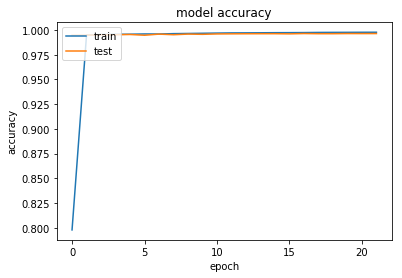

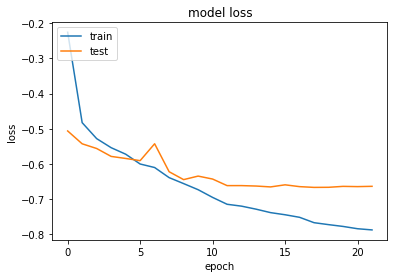

In [11]:
# View training statistics
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Quickly view predictions on patches with the trained model.
# Predictions for larger data will need to be done in the next notebook.

test_gen = DataGen(valid_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=0)
x, y = test_gen.__getitem__(0)
result = model.predict(x)

n=100
z=8

print(x.shape)
display_slice_from_batch(x,n,z)
display_slice_from_batch(y,n,z)
display_slice_from_batch(result,n,z)

In [14]:
# Run this if you want to save the training history
import pickle
with open('trainHistoryDict_overnight', 'wb') as handle: # saving the history of the model
    pickle.dump(history.history, handle)